In [1]:
import torch
import pickle
from control_torch import drss, set_seed, forced_response, tf2ss, c2d, perturb_matrices
import numpy as np
from pathlib import Path
import time
import torch
import numpy as np

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_onestep import GPTConfig, GPT
from transformer_onestep_CL import GPTClosedLoop



In [2]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 50 # 256

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")

In [3]:
import pickle
test_set_len = 30
# Load the test set from the pickle file
with open('test_set_lin_1.pkl', 'rb') as f:
    test_set = pickle.load(f)

/home/rbusetto/.virtualenvs/in-context-controller/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.Bytes

In [4]:
print(test_set[0])

(tensor([[ 0.0189,  0.2149],
        [-0.0156,  0.0624]], device='cuda:0'), tensor([[ 0.0846],
        [-0.1343]], device='cuda:0'), tensor([[-0.5698,  1.1014]], device='cuda:0'), tensor([[0.]], device='cuda:0'))


In [5]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_onestep_gen_lin_2.6.pt", map_location=device)

/tmp/ipykernel_48394/2509782831.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp_data = torch.load(out_dir/"ckpt_onestep_gen_lin_2.6.pt", map_location=device)


In [6]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx
model_args = exp_data["model_args"]
# model_args['use_p'] = True
# model_args['use_i'] = True
# model_args['use_d'] = False
gptconf = GPTConfig(**model_args)
model_CL = GPTClosedLoop(gptconf).to(device)

state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model_CL.load_state_dict(state_dict)
model = model_CL.gpt_model
print(f"Best validation loss: {exp_data['best_val_loss']}")

number of parameters: 0.11M
Best validation loss: 0.5658430457115173


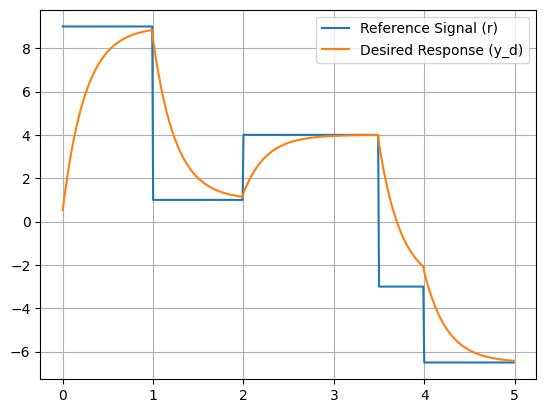

In [7]:
set_seed(42)
T = 5
ts = 1e-2
t = torch.arange(0, T, ts, device=device, dtype=torch.float32).view(-1, 1)
r = torch.ones_like(t, device=device, dtype=torch.float32)
r[t < 1] = np.random.choice(np.arange(-10,10,.5))
r[(t >= 2) & (t < 3.5)] = np.random.choice(np.arange(-10,10,.5))
r[(t >= 3.5) & (t < 4)] = np.random.choice(np.arange(-10,10,.5))
r[(t >= 4) & (t < 5)] = np.random.choice(np.arange(-10,10,.5))

tau = 1
M_num = torch.tensor([0.01, 1], device=device, dtype=torch.float32)  # Numerator coefficients
M_den = torch.tensor([tau/4, 1], device=device, dtype=torch.float32)  # Denominator coefficients
M = tf2ss(M_num, M_den, device=device)
M_d = c2d(*M, ts, device=device)
y_d = forced_response(*M_d, r)

plt.plot(t.cpu().numpy(), r.cpu().numpy(), label='Reference Signal (r)')
plt.plot(t.cpu().numpy(), y_d.cpu().numpy(), label='Desired Response (y_d)')
plt.grid(True)
plt.legend()

In [8]:
H = 500 # this could need tuning
noisy = False
YY = torch.zeros([test_set_len,len(t),1], device=device, dtype=torch.float32)

for j, system in enumerate(test_set):
    print('system n.', j)
    E = torch.empty_like(t, device=device, dtype=torch.float32).reshape(1,-1,1)
    U = torch.empty(t.size(0)+1, device=device, dtype=torch.float32).reshape(1,-1,1)
    Y = torch.empty_like(t, device=device, dtype=torch.float32).reshape(1,-1,1)
    
    with torch.no_grad():
        # initial
        U[0,0,0] = 0
        y_i = 0
        x_i = torch.zeros(nx, device=device, dtype=torch.float32)
        
        for i in range(len(t)):
            # start the loop with error
            e_i = r[i] - y_i
                
            Y[0,i,0] = y_i
            E[0,i,0] = e_i
            
            # Controller u(t) = C(e(t),u(t-1))
            if i < H:
                pred = model(E[:, :i+1, :], U[:, :i+1, :])
            else:
                pred = model(E[:, i-H+1:i+1, :], U[:, i-H+1:i+1, :])
                
            U[0,i+1,0] = pred[0,-1,0] # just for coherence, it could be directly be u_i_prev
            # Generate a single value from white noise with 0 mean and 1 std dev
            if noisy :
                white_noise_value1 = torch.randn(1).item()  
                white_noise_value2 = torch.randn(1).item() 
                white_noise_value3 = torch.randn(1).item()
                state_noise = torch.tensor([white_noise_value1, white_noise_value2],device = device, dtype=torch.float32)
                y, x_i = forced_response(*system, U[0,i:i+2,:], return_x=True, x0= x_i + state_noise)
            
                y_i = y[-1] + white_noise_value3
            else : 
                y, x_i = forced_response(*system, U[0,i:i+2,:], return_x=True, x0= x_i)
            
                y_i = y[-1]
    YY[j,:,0] = Y[0,:,0]

system n. 0
system n. 1
system n. 2
system n. 3
system n. 4
system n. 5
system n. 6
system n. 7
system n. 8
system n. 9
system n. 10
system n. 11
system n. 12
system n. 13
system n. 14
system n. 15
system n. 16
system n. 17
system n. 18
system n. 19
system n. 20
system n. 21
system n. 22
system n. 23
system n. 24
system n. 25
system n. 26
system n. 27
system n. 28
system n. 29


In [9]:
import numpy as np
import matplotlib.pyplot as plt


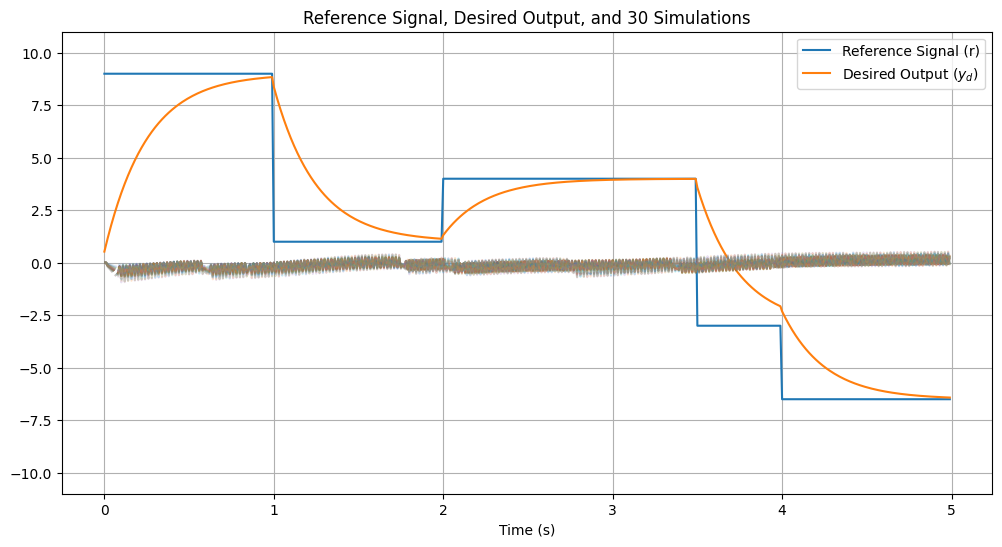

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(t.cpu().numpy(), r.cpu().numpy(), label='Reference Signal (r)', alpha=1)
plt.plot(t.cpu().numpy(), y_d.cpu().numpy(), label='Desired Output ($y_{d}$)', alpha=1)

for i in range(test_set_len):
    plt.plot(t.cpu().numpy(), YY[i, :, 0].cpu().numpy(), linestyle='-.', alpha=0.2)

plt.xlabel('Time (s)')
plt.title('Reference Signal, Desired Output, and 30 Simulations')
plt.ylim([-11, 11])
plt.legend()
plt.grid(True)
plt.show()

In [11]:
##MEAN SQUARED ERROR
mse_tot = 0
for i in range(test_set_len):
    error = np.array(y_d.cpu() - YY[i].cpu())
    squared_error_sum = 0
    for i in range(len(error)) :
        squared_error_sum = squared_error_sum + (error[i]*error[i])
    mse = squared_error_sum / len(error)
    print('mse : ',mse)
    mse_tot += mse

MSE = mse_tot / test_set_len
print('MSE:' ,MSE)



mse :  [24.434872]
mse :  [24.545912]
mse :  [24.378145]
mse :  [24.892342]
mse :  [24.017992]
mse :  [24.572695]
mse :  [24.765911]
mse :  [24.841244]
mse :  [25.009249]
mse :  [24.557274]
mse :  [24.184813]
mse :  [24.783]
mse :  [25.318893]
mse :  [24.639215]
mse :  [24.497211]
mse :  [24.705692]
mse :  [24.401773]
mse :  [24.418983]
mse :  [24.066988]
mse :  [24.667555]
mse :  [24.659191]
mse :  [24.494997]
mse :  [24.44442]
mse :  [24.634266]
mse :  [24.334698]
mse :  [24.828474]
mse :  [24.165682]
mse :  [25.24164]
mse :  [23.807777]
mse :  [25.246067]
MSE: [24.585234]
